In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'

In [2]:
""" Import modules """
import torch
from torch import nn
import time
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration, AdamW
import pandas as pd
import os
os.chdir("/home/rahpon/projects/Misogyny_meme1")
import re
import cv2
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch import nn
import matplotlib.pyplot as plt
import timm
from datetime import datetime 
# storing the current time in the variable
dt = datetime.now()

# """ set necessary environment variables """
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

""" 
Load models for vision and text - ViT and llama
Also load tokenizer
"""
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoConfig

double_quant_config = BitsAndBytesConfig(
    # load_in_4bit=True,
    # bnb_4bit_use_double_quant=True,
    # bnb_4bit_compute_dtype=torch.float16,
    load_in_8bit=True,
)

In [3]:
""" set device """
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("abhinand/tamil-llama-7b-base-v0.1", low_cpu_mem_usage=True, torch_dtype=torch.float16)
# Load the model configuration
config = AutoConfig.from_pretrained("abhinand/tamil-llama-7b-base-v0.1", low_cpu_mem_usage=True, quantization_config=double_quant_config, torch_dtype=torch.float16)
# Initialize the model architecture from the configuration

from accelerate import init_empty_weights
with init_empty_weights():
#     llama_clf = TextModel(model).half()
    model = AutoModelForCausalLM.from_config(config)
# model = model

print("Text Model loaded")

# from transformers import CLIPModel
img_model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=2)

print("Image Model loaded")


""" 
set dataset location
folder - path containing tamil & malayalam folders
"""
folder = "training_data"
language = "tamil"  # set accordingly
dpth = os.path.join(folder, language)

""" hyper-parameters """
N = 16       # batch-size
T = 0.07     # temperature factor
epochs = 10

""" 
Use for adding extra token - [PAD], for padding all to same length
Later re-train the model for learning an embedding corresponding to the new vocab element
"""
tokenizer.all_special_ids
special_tokens_dict = {"pad_token" : '[PAD]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
tok_id = tokenizer.convert_tokens_to_ids('[PAD]')
model.resize_token_embeddings(len(tokenizer))    # resizing embedding matrix of model to accomodate new [PAD]

class LanData(Dataset):
    def __init__(self, mode, dpth):
        """
        Dataset class for loading images and transcriptions of memes
        Add dataset path got above as parameter(dpth)
        mode = train/test, to get training/testing dataset (saved as test and train folders in language folder)
        """

        self.path = os.path.join(dpth, mode)   # mode = train/test
        tscpts = os.path.join(self.path, mode + ".csv")
        self.csv = pd.read_csv(tscpts).dropna(axis = 0)
        toks = tokenizer(self.csv.transcriptions.tolist(), truncation=True, max_length=75, padding = 'max_length', return_tensors = 'pt')
        self.csv["tokens"] = toks.input_ids.tolist()
        self.csv["masks"] = toks.attention_mask.tolist()

        ims = []
        labs = []
        scpts = []
        ms = []
        imageIDs = []
        mu = torch.zeros((1, 3, 1, 1))
        sigma = torch.zeros((1, 3, 1, 1))

        """
        Iterate over all images
        Get mu (mean) and sigma (std-dev) of images
        Normalize for better image pixel value distribution for better training
        """
        tot = 0
        for f in os.listdir(self.path):
            if ".csv" in f:
                continue

            # move-on only if valid datapoint, i.e. has a transcript
            iid = int(f.split('.')[0])
            if iid not in self.csv.image_id.tolist():
                continue
            imageIDs.append(iid); tot += 1

            # image
            ig = cv2.imread(os.path.join(self.path, f))
            ig = cv2.resize(ig, (224, 224), interpolation = cv2.INTER_CUBIC)
            ig = torch.tensor(ig.reshape(1, 3, 224, 224)) / ig.max()
            ims.append(ig)
            mu += ig.mean([2, 3]).reshape((1,3,1,1))
            sigma += ig.std([2, 3]).reshape((1,3,1,1))
        mu /= tot
        sigma /= tot

        tr = 0
        for iid, ig in zip(imageIDs, ims):
            # image
            ig = (ig - mu) / sigma
            ims[tr] = ig
            tr += 1

            #label
            l = self.csv[self.csv.image_id == iid]["labels"].astype(float)
            labs.append(l)

            # transcripts
            s = self.csv[self.csv.image_id == iid]["tokens"].tolist()[0]
            scpts.append(s)

            # masks
            m = self.csv[self.csv.image_id == iid]["masks"].tolist()[0]
            ms.append(m)
            
            if int(l.iloc[0]) == 1 and mode == "train":
                labs.extend([l,] * 3)
                scpts.extend([s,] * 3)
                ms.extend([m,] * 3)
                ims.extend([ig,] * 3)

        self.images = torch.cat(ims, dim = 0)
        self.labels = labs
        self.tokens = scpts
        self.masks = ms
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, ix):
        return self.images[ix].to(torch.float16), torch.tensor(self.labels[ix].item()).to(torch.float16), torch.tensor(self.tokens[ix]), torch.tensor(self.masks[ix]).to(torch.float16)

""" Load datasets using class above """
train_data = LanData("train", dpth)
test_data = LanData("test", dpth)

""" Creat pytorch dataloaders from nn.dataset classes above """
train_loader = DataLoader(train_data, batch_size = N, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data, batch_size = N, shuffle = True, drop_last = True)

class ImageEmbedding(nn.Module):
    def __init__(self, vit):
        super(ImageEmbedding, self).__init__()
        vit.head = nn.Linear(768, 128)
        self.embedding = vit

    def forward(self, x):
        return self.embedding(x)




class TextEmbedding(nn.Module):
    def __init__(self, text_model):
        super(TextEmbedding, self).__init__()
        text_model.clf_head[4] = nn.Linear(512, 128, bias = False)
        self.embedding = text_model

    def forward(self, x, mask):
        return self.embedding(x, mask)
      

class TextModel(nn.Module):
    """
    Text classification model using llama
    Keep llama except the final decoding layer
    Add linear layers to transform into a lower dimensional embedding
    Add classification head
    """
    def __init__(self, llama):
        """ Pass in the loaded pre-trained llama """
        super(TextModel, self).__init__()
        self.text_base = llama.model
        self.clf_head = nn.Sequential(
            nn.Linear(4096, 512, bias = False),
            nn.Dropout(0.5, inplace = False),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, 1, bias=False)
        )

    def forward(self, x, mask):
        text_hidden = self.text_base(x, attention_mask = mask).last_hidden_state.mean(1)
        clf_out = self.clf_head(text_hidden)

        return clf_out



class Ensemble(nn.Module):
    """
    Receives combined logits from both image and text model
    passed to L1 : a linear layer (4 parameters)
    then sigmoid output for final decision logit
    """
    def __init__(self, fusion = "concat"):
        super(Ensemble, self).__init__()
        self.fusion = fusion
        if self.fusion == "concat":
            self.d = 256
        elif self.fusion == "element":
            self.d = 128
        elif self.fusion == "sumpool":
            self.w1 = nn.Linear(128, 64, bias = False)
            self.w2 = nn.Linear(128, 64, bias = False)
            self.sumpool = nn.AvgPool1d(4)
            self.d = 16
        elif self.fusion == "gated":
            self.U = nn.Linear(128, 64, bias = False)
            self.sig = nn.Sigmoid()
            self.V = nn.Linear(128, 64, bias = False)
            self.W = nn.Linear(64, 8, bias = False)
            self.d = 8

        self.initial = nn.Linear(self.d, self.d // 2, bias = True)
        self.final = nn.Linear(self.d // 2, 1, bias = True)
        self.act_out = nn.Sigmoid()

    def forward(self, d1, d2):
        if self.fusion == "concat":
            fused = torch.concat([d1, d2], dim = -1)
        elif self.fusion == "element":
            fused = d1 * d2
        elif self.fusion == "sumpool":
            venc = self.w1(d1)
            tenc = self.w2(d2)
            fused = self.sumpool(venc * tenc)
        elif self.fusion == "gated":
            tenc = self.sig(self.U(d1))
            venc = self.V(d2)
            enc = tenc * venc
            fused = self.W(enc)
        hidden = self.initial(fused)
        out = self.final(hidden)

        if self.training == False:
            out = self.act_out(out)
            
        return out

Text Model loaded
Image Model loaded


In [4]:
elr = 1e-5

save_model_path = "saved_models/"+str(language)+"custom_"+str(language)+"_llamavit_fusionsumpool_pretrained_"+str(elr)+"_"+str(epochs)+"_"+str(N)+"/"
# isExist = os.path.exists(save_model_path)
# if not isExist:
#     # Create a new directory because it does not exist
#     os.makedirs(save_model_path)


# torch.save(llama_clf.state_dict(), save_model_path+"text_model.bin") # text model
# torch.save(vit_clf.state_dict(), save_model_path+"image_model.bin") # image model
# torch.save(stacker.state_dict(), save_model_path+"stacker.bin") # ensemble model

In [5]:
# from accelerate import init_empty_weights
# with init_empty_weights():
#     llama_clf = TextModel(model).half()

In [ ]:
# # Initialize the models
llama_clf = TextModel(model).half()
vit_clf = img_model.half()
llama_clf = TextEmbedding(llama_clf).half()
vit_clf = ImageEmbedding(vit_clf).half()
stacker = Ensemble(fusion="element").half()

# Load the saved weights with strict=False to ignore missing keys
llama_clf.load_state_dict(torch.load(save_model_path + "text_model.bin",weights_only=True), strict=False)
vit_clf.load_state_dict(torch.load(save_model_path + "image_model.pt",weights_only=True), strict=False)
stacker.load_state_dict(torch.load(save_model_path + "stacker.pt",weights_only=True), strict=False)

llama_clf = llama_clf.to_empty(device=device)
vit_clf = vit_clf.to_empty(device=device)
stacker = stacker.to_empty(device=device)

llama_clf = nn.DataParallel(llama_clf)
vit_clf = nn.DataParallel(vit_clf)
stacker = nn.DataParallel(stacker)


In [ ]:
# llama_clf = TextModel(model).half().to(device)
# llama_clf.load_state_dict(torch.load(save_model_path+"text_model.pt"),strict=False)
# vit_clf = img_model.half().to(device)
# vit_clf.load_state_dict(torch.load(save_model_path+"image_model.bin"),strict=False)
# stacker = Ensemble(fusion = "element").half().to(device)
# stacker.load_state_dict(torch.load(save_model_path+"stacker.bin"),strict=False)


# from accelerate import Accelerator
# from accelerate.utils import load_and_quantize_model
# accelerate = Accelerator()
# # accelerate.save_model(llama_clf, save_model_path)
# from accelerate.utils import BnbQuantizationConfig
# bnb_quantization_config = BnbQuantizationConfig(load_in_8bit=True, llm_int8_threshold = 6)

# llama_clf = load_and_quantize_model(model, weights_location=save_model_path, bnb_quantization_config=bnb_quantization_config, device_map = "auto")

# Initialize the models
# llama_clf = TextModel(model).half()
# vit_clf = img_model.half()
# llama_clf = TextEmbedding(llama_clf).half()
# vit_clf = ImageEmbedding(vit_clf).half().to(device)
# stacker = Ensemble(fusion="element").half().to(device)



# Load the saved weights with strict=False to ignore missing keys
# llama_clf.load_state_dict(torch.load(save_model_path + "text_model.bin"), strict=False)
# vit_clf.load_state_dict(torch.load(save_model_path + "image_model.bin"), strict=False)
# stacker.load_state_dict(torch.load(save_model_path + "stacker.bin"), strict=False)


In [ ]:
# testing
llama_clf.eval()
vit_clf.eval()
stacker.eval()
ths = [x/10 for x in range(1, 10)] # 0.1 - 1
accs = []
criterion = nn.BCEWithLogitsLoss()

for th in ths:
    test_loss = 0
    its = 0
    correct = 0

    with tqdm(test_loader, unit = "batch") as test_epoch:
        for img, lab, text, mask in test_epoch:
            img, lab, text, mask = img.to(device), lab.to(device), text.to(device), mask.to(device)
            test_epoch.set_description(f"Testing...")
            batch_loss = 0

            d1 = llama_clf(text, mask).to(device)
            d2 = vit_clf(img).to(device)

            out = stacker(d1, d2).squeeze(1).to(device)

            pred = (out > th).to(torch.float)
            correct += (pred == lab).sum()

            batch_loss = criterion(out, lab)

            test_loss += batch_loss.item()
            its += 1

    test_loss /= its
    accuracy = (correct / (its * 16)).item() # its --> number of items ;  16 --> batch size
    
    accs.append(accuracy)

    print(f"Accuracy: {accuracy * 100:.2f} %")
print(f"Average test set loss:  {test_loss:.5f}")

best_thr = ths[accs.index(max(accs))]
print(f"Best threshold computed at: {best_thr}")

print("Now producing results at best threshold:-")

preds = []
tru = []

test_loss = 0
its = 0
correct = 0

with tqdm(test_loader, unit = "batch") as test_epoch:
    for img, lab, text, mask in test_epoch:
        img, lab, text, mask = img.to(device), lab.to(device), text.to(device), mask.to(device)
        test_epoch.set_description(f"Testing...")
        batch_loss = 0

        d1 = llama_clf(text, mask)
        d2 = vit_clf(img)

        out = stacker(d1, d2).squeeze(1)

        pred = (out > best_thr).to(torch.float)
        correct += (pred == lab).sum()

        batch_loss = criterion(out, lab)

        test_loss += batch_loss.item()
        its += 1
        preds.extend(pred.tolist())
        tru.extend(lab.tolist())

test_loss /= its
accuracy = (correct / (its * 16)).item()

print(f"Accuracy: {accuracy * 100:.2f} %")
print(f"Average test set loss:  {test_loss:.5f}")


# plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix(tru, preds)).plot()

# create directories to save models and metrices
# save_model_path = "saved_models/"+str(language)+"/text/tamilllama/"
# save_confusion_matrix_path = "explanation/predictions/"+str(language)+"/fusion/"
# metrices_path = "explanation/predictions/"+str(language)+"/fusion/"


# isExist = os.path.exists(save_model_path)
# if not isExist:
#     # Create a new directory because it does not exist
#     os.makedirs(save_model_path)
# isExist = os.path.exists(save_confusion_matrix_path)
# if not isExist:
#     # Create a new directory because it does not exist
#     os.makedirs(save_confusion_matrix_path)
# isExist = os.path.exists(metrices_path)
# if not isExist:
#     # Create a new directory because it does not exist
#     os.makedirs(metrices_path)
# save predictions
# preds_df = pd.DataFrame({'predictions':preds})
# preds_df.to_csv(save_confusion_matrix_path+"custom_"+str(language)+"_llamavit_fusionsumpool_pretrained_"+str(elr)+"_"+str(epochs)+"_"+str(N)+".csv", index = False)

# saving confusion matrix plot
# plt.savefig(save_confusion_matrix_path+"custom_"+str(language)+"_llamavit_fusionsumpool_pretrained_"+str(elr)+"_"+str(epochs)+"_"+str(N)+".png")
print(classification_report(tru, preds, digits = 5))

# cf = confusion_matrix(tru, preds)
# cr = classification_report(tru, preds, digits = 5)
# # saving metrices and confussion matrix
# with open(metrices_path+"custom_"+str(language)+"llama_vit_"+fusion_method+"fusion_"+str(N)+".txt", "a") as text_file:
#     text_file.write("Date and time of run = "+str(dt)+"\n")
#     text_file.write(str(elr)+"_"+str(epochs)+"_"+str(N)+"\n\n")
#     text_file.write(str(cf)+"\n")
#     text_file.write(cr)
#     text_file.write("\n\n\n")

Trying to save model in multimodal setting

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

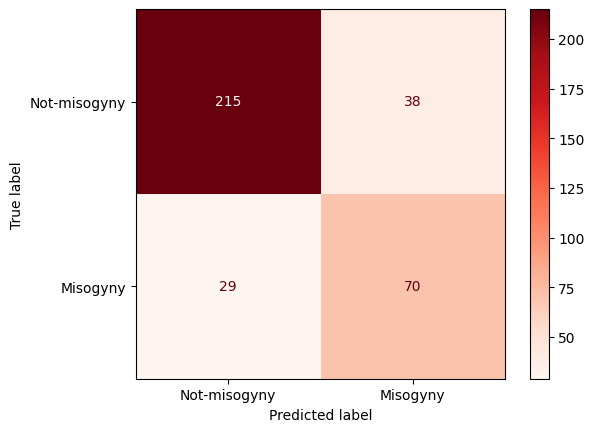

In [8]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

cm = np.array([[215,38],[29,70]])

disp = ConfusionMatrixDisplay(cm,display_labels=["Not-misogyny","Misogyny"])
disp.plot(cmap='Reds')